# UFC Fighter Rankings Using PageRank and Networkx
Based off an [blog post](https://towardsdatascience.com/ranking-the-best-ufc-fighters-using-pagerank-and-neo4j-5385805b4515) I wrote a few years back but with refreshed data and a different graph database library

### Goal:
In this notebook, I will show how the PageRank algorithm, originally developed by Google to rank webpages, can be used to rank UFC fighters.

In [5]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from datetime import timedelta, time, datetime
import networkx as nx
import seaborn as sns

### Getting The Data
The UFC publishes fight results for all its events dating back to 1993 on http://ufcstats.com. In order to obtain this data, I wrote a Python scraper to scrape the site and save the results. More in depth descriptions and usage examples of the scraper can be found on my github [here](https://github.com/swang2016/ufc_scraper). 

A preview of the fight data is below:

In [148]:
#load fight data
fights = pd.read_csv('/ufc_scraper/data/fight_hist.csv')

#ignore DQs
fights = fights[fights.method != 'DQ']

fights = fights.reset_index(drop = True)

#remove apostrophes from womens divisions
fights['division'] = fights.division.str.replace("'", '')

# only look at Wins for directed graph since Losses are just dupes. Graph direction will be loser ->> winner
fights = fights[fights.result == 'W']

# convert date to pandas datetime
fights['date'] = pd.to_datetime(fights.date)

In [149]:
fights.head()

,date,fight_url,event_url,result,fighter,opponent,division,method,round,time,fighter_url,opponent_url,knockdowns,sub_attempts,reversals,control_time,takedowns_landed,takedowns_attempts,sig_strikes_landed,sig_strikes_attempts,total_strikes_landed,total_strikes_attempts,head_strikes_landed,head_strikes_attempts,body_strikes_landed,body_strikes_attempts,leg_strikes_landed,leg_strikes_attempts,distance_strikes_landed,distance_strikes_attempts,clinch_strikes_landed,clinch_strikes_attempts,ground_strikes_landed,ground_strikes_attempts
0,2024-04-13,http://ufcstats.com/fight-details/e4931f3ab3bf...,http://ufcstats.com/event-details/6750e338922a...,W,Alex Pereira,Jamahal Hill,Light Heavyweight,KO/TKO,1,3:14,http://ufcstats.com/fighter-details/e5549c82bf...,http://ufcstats.com/fighter-details/5444c5a201...,1,0,0,0:07,0,0,24,30,24,30,12,15,6,6,6,9,13,16,0,0,11,14
2,2024-04-13,http://ufcstats.com/fight-details/66eddbe35056...,http://ufcstats.com/event-details/6750e338922a...,W,Zhang Weili,Yan Xiaonan,Womens Strawweight,U-DEC,5,5:00,http://ufcstats.com/fighter-details/1ebe20ebbf...,http://ufcstats.com/fighter-details/c41d426cc7...,0,2,0,12:44,6,9,106,157,256,327,84,119,13,19,9,19,34,78,1,1,71,78
4,2024-04-13,http://ufcstats.com/fight-details/cf5e8f98159c...,http://ufcstats.com/event-details/6750e338922a...,W,Max Holloway,Justin Gaethje,Lightweight,KO/TKO,5,4:59,http://ufcstats.com/fighter-details/150ff4cc64...,http://ufcstats.com/fighter-details/9e8f6c728e...,1,0,0,0:00,0,0,181,309,181,309,62,149,62,91,57,69,181,308,0,1,0,0
6,2024-04-13,http://ufcstats.com/fight-details/01f7c2880474...,http://ufcstats.com/event-details/6750e338922a...,W,Arman Tsarukyan,Charles Oliveira,Lightweight,S-DEC,3,5:00,http://ufcstats.com/fighter-details/eae48ff31d...,http://ufcstats.com/fighter-details/07225ba28a...,0,0,1,8:41,2,4,49,83,75,117,37,69,10,11,2,3,23,50,3,4,23,29
8,2024-04-13,http://ufcstats.com/fight-details/0c2e3988793b...,http://ufcstats.com/event-details/6750e338922a...,W,Bo Nickal,Cody Brundage,Middleweight,SUB,2,3:38,http://ufcstats.com/fighter-details/35673bf520...,http://ufcstats.com/fighter-details/f14f644d41...,0,2,0,7:25,3,6,8,13,45,59,6,11,2,2,0,0,3,5,0,0,5,8


In [150]:
len(fights)

7434

### Loading Fight Data Into A Graph Using Networkx
As a small example and for visualization purposes, we will load the UFC record of Islam Makhachev, current Lightweight champion (as of April 2024).

We can see that Islam has won all of his fights in the UFC accept for his second fight against Adriano Martins on October 3 2015. We will design the graph data model as so:
* Each fighter will be assigned to a node
* Edges will be directed so that if fighter A lost to fighter B, there will be an edge going from fighter A to fighter B

In [55]:
# look at an example with just one fighter, Islam Makhachev
im_fights = fights[(fights.fighter == 'Islam Makhachev') | (fights.opponent == 'Islam Makhachev')]

# can see that islam has won all his fights accept for this second fight against Adriano Martins on October 3 2015
im_fights

,date,fight_url,event_url,result,fighter,opponent,division,method,round,time,fighter_url,opponent_url,knockdowns,sub_attempts,reversals,control_time,takedowns_landed,takedowns_attempts,sig_strikes_landed,sig_strikes_attempts,total_strikes_landed,total_strikes_attempts,head_strikes_landed,head_strikes_attempts,body_strikes_landed,body_strikes_attempts,leg_strikes_landed,leg_strikes_attempts,distance_strikes_landed,distance_strikes_attempts,clinch_strikes_landed,clinch_strikes_attempts,ground_strikes_landed,ground_strikes_attempts
468,2023-10-21,http://ufcstats.com/fight-details/0ea435ddf02d...,http://ufcstats.com/event-details/13a0fb8fbdaf...,W,Islam Makhachev,Alexander Volkanovski,Lightweight,KO/TKO,1,3:06,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/e124894134...,1,0,0,0:19,0,1,24,29,39,46,13,16,9,11,2,2,7,11,8,9,9,9
1262,2023-02-11,http://ufcstats.com/fight-details/256894b49303...,http://ufcstats.com/event-details/01dd4cdc2446...,W,Islam Makhachev,Alexander Volkanovski,Lightweight,U-DEC,5,5:00,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/e124894134...,0,0,0,7:37,4,9,57,95,95,135,36,72,18,20,3,3,45,82,12,13,0,0
1534,2022-10-22,http://ufcstats.com/fight-details/523815acf1bb...,http://ufcstats.com/event-details/885e7f70dcac...,W,Islam Makhachev,Charles Oliveira,Lightweight,SUB,2,3:16,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/07225ba28a...,1,1,0,5:05,2,3,30,41,72,86,25,35,5,6,0,0,21,31,5,5,4,5
2240,2022-02-26,http://ufcstats.com/fight-details/2f4d42e0b969...,http://ufcstats.com/event-details/f6a7b02c42e9...,W,Islam Makhachev,Bobby Green,Catch Weight,KO/TKO,1,3:23,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/887961364b...,0,0,0,1:57,1,2,14,32,30,51,10,27,2,2,2,3,3,10,2,2,9,20
2538,2021-10-30,http://ufcstats.com/fight-details/5ad4c0eae751...,http://ufcstats.com/event-details/3974fa35c917...,W,Islam Makhachev,Dan Hooker,Lightweight,SUB,1,2:25,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/193b9d1858...,0,2,0,1:48,1,1,2,3,13,14,2,3,0,0,0,0,2,3,0,0,0,0
2840,2021-07-17,http://ufcstats.com/fight-details/7d4c160dab6e...,http://ufcstats.com/event-details/40389d39a92f...,W,Islam Makhachev,Thiago Moises,Lightweight,SUB,4,2:38,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/d945aae53e...,0,1,1,8:11,3,6,61,92,148,194,28,56,31,34,2,2,22,41,27,31,12,20
3216,2021-03-06,http://ufcstats.com/fight-details/c06d7bb29bc2...,http://ufcstats.com/event-details/6e2b1d631832...,W,Islam Makhachev,Drew Dober,Lightweight,SUB,3,1:37,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/519e4fe37c...,0,2,0,9:26,3,4,15,25,102,119,12,22,2,2,1,1,5,14,1,1,9,10
4630,2019-09-07,http://ufcstats.com/fight-details/849eb47d349f...,http://ufcstats.com/event-details/a79bfbc01b22...,W,Islam Makhachev,Davi Ramos,Lightweight,U-DEC,3,5:00,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/0052de9069...,1,0,0,4:39,0,1,43,95,88,148,32,81,7,10,4,4,29,74,3,3,11,18
5042,2019-04-20,http://ufcstats.com/fight-details/103a7d8c4f17...,http://ufcstats.com/event-details/7dcf06c19678...,W,Islam Makhachev,Arman Tsarukyan,Lightweight,U-DEC,3,5:00,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/eae48ff31d...,0,0,0,6:06,4,9,14,20,47,53,7,12,6,6,1,2,4,10,8,8,2,2
5746,2018-07-28,http://ufcstats.com/fight-details/e54c16d86787...,http://ufcstats.com/event-details/322a56923b39...,W,Islam Makhachev,Kajan Johnson,Lightweight,SUB,1,4:43,http://ufcstats.com/fighter-details/275aca31f6...,http://ufcstats.com/fighter-details/633a45d131...,0,1,0,1:28,1,1,7,18,14,26,6,17,1,1,0,0,1,9,0,0,6,9


We can visualize Islam's fights in a graph below. Notice that for fights that he has won, the losing fighers' nodes have edges pointing to his node and for the one fight he lost, his node has an edge pointing to Adriano Martins. This is important to note for PageRank which we will cover later

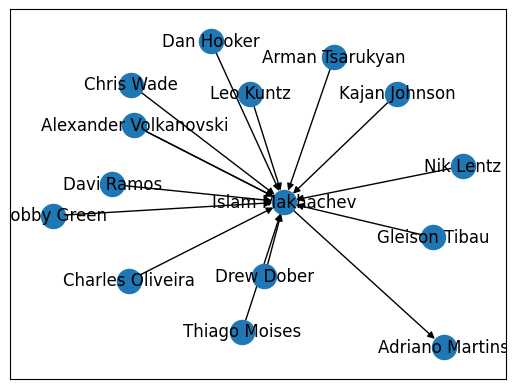

In [151]:
# convert to dictionary to load into graph
im_dict = im_fights.to_dict(orient = 'records')

# initialize a multidirectional graph (directed graph with possible repeating edges between nodes)
im_graph = nx.MultiDiGraph()
for fight in im_dict:
    im_graph.add_edge(fight['opponent'], fight['fighter'])

# visualize it
nx.draw_networkx(im_graph)

### Creating Graphs For More Fighters and Fights
For this analysis we will create graphs for separate weight divisions since fighters mostly fight within their own divisions. We will create graphs for bantamweight, featherweight, and lightweight divisions because they are the most competitive in the UFC. And for fun we will add a graph for the heavyweight division too because watching big guys swang and bang gets the people going!

In [152]:
# we will now create graphs for bantamweight, featherweight, and lightweight divisions because they are the most competitive
# Add in heavyweight too because watching big guys swang and bang gets the people going!

divisions = ['Lightweight', 'Featherweight', 'Bantamweight', 'Heavyweight']

# function to create divisions graph
def create_division_graph(
        fight_df: pd.DataFrame, 
        division: str, 
        end_date = pd.to_datetime(datetime.now().date())
        ) -> nx.Graph:
    # create list of dicts of weight division
    fight_dict = fight_df[(fight_df.division == division) & (fight_df.date <= end_date)].to_dict(orient = 'records')

    # intialize empty graph
    G = nx.MultiDiGraph(title=division)
    for fight in fight_dict:
        G.add_edge(fight['opponent'], fight['fighter'])
    
    return G

division_graphs = []
for div in divisions:
    division_graph = create_division_graph(fights, div)
    division_graphs.append(division_graph)

### A very brief explanation of PageRank
Originally developed by Larry Page and Sergey Brin, PageRank was used in Google’s search engine to rank the relevance of linked webpages. Using webpages as nodes and links as edges in a directed graph, the general idea of PageRank is as follows:

* pages with many other pages linked to it will have higher relevance
* having links from high relevance pages increases relevance
* pages pass relevance to the neighbors they link to

Using the original webpage ranking use case as an example, a website like Twitter would have a high PageRank since many other sites link to it. Likewise, a site with links from a popular site like Twitter would also have a high relevance from a PageRank perspective. The image below demonstrates this idea:

![Alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ySWK5_u1Sn2s_qEbzft8jg.png "a title")

Node B has the highest PageRank because it not only has many nodes linking to it but also because it has links from nodes with relatively high relevance. Though node C only has only one link directed to it, it has a high PageRank because that one link comes from node B, the most important node in the network. Nodes A, D, and F have low PageRanks because they only have a few relatively unimportant nodes linking to them.

With an understanding of the above example, we can see how PageRank can also be translated to UFC fighters. Fighters with more wins (more edges incoming) and wins over highly ranked fighters (incoming edges from important nodes) will be more highly ranked with PageRank.

### Implementing Pagerank using Networkx
In the cells below we define a function for pagerank and apply it on all the weight division graphs we just created. 

In [153]:
# function to calculate for each node in a graph, returns
def calc_page_rank(G: nx.Graph) -> dict:
    graph_title = G.graph.get('title', 'Unnamed')
    pageranks = nx.pagerank(G)
    return {'title': graph_title, 'pageranks': pageranks}

# now lets calculate pagerank for each division
pagerank_dict = {}
for G in division_graphs:
    pagerank = calc_page_rank(G)
    pagerank_dict[pagerank.get('title')] = pagerank.get('pageranks')

### Top 10 Lightweight Division Fighter Pageranks

In [154]:
# top 10 fighters in Lightweight division
lightweight = pd.DataFrame.from_dict(pagerank_dict.get('Lightweight'), orient = 'index')
lightweight = lightweight.reset_index()
lightweight.columns = ['fighter', 'pagerank']
lightweight = lightweight.sort_values('pagerank', ascending=False)
lightweight.head(10)

,fighter,pagerank
173,Donald Cerrone,0.024769
2,Charles Oliveira,0.022887
48,Beneil Dariush,0.020605
19,Dustin Poirier,0.019824
233,Adriano Martins,0.018880
63,Islam Makhachev,0.018794
20,Rafael Dos Anjos,0.017038
0,Justin Gaethje,0.016421
161,Kevin Lee,0.014394
151,Khabib Nurmagomedov,0.014272


### Top 10 Featherweight Division Fighter Pageranks

In [155]:
# top 10 fighters in Featherweight division
featherweight = pd.DataFrame.from_dict(pagerank_dict.get('Featherweight'), orient = 'index')
featherweight = featherweight.reset_index()
featherweight.columns = ['fighter', 'pagerank']
featherweight = featherweight.sort_values('pagerank', ascending=False)
featherweight.head(10)

,fighter,pagerank
33,Ilia Topuria,0.044047
65,Max Holloway,0.035530
32,Alexander Volkanovski,0.033422
252,Conor McGregor,0.017660
184,Jose Aldo,0.016190
28,Yair Rodriguez,0.015610
70,Cub Swanson,0.015365
0,Calvin Kattar,0.015358
47,Josh Emmett,0.015224
29,Brian Ortega,0.014524


### Top 10 Bantamweight Division Fighter Pageranks

In [156]:
# top 10 fighters in Bantamweight division
bantamweight = pd.DataFrame.from_dict(pagerank_dict.get('Bantamweight'), orient = 'index')
bantamweight = bantamweight.reset_index()
bantamweight.columns = ['fighter', 'pagerank']
bantamweight = bantamweight.sort_values('pagerank', ascending=False)
bantamweight.head(10)

,fighter,pagerank
14,Marlon Vera,0.041218
62,Aljamain Sterling,0.036904
78,Raphael Assuncao,0.028257
76,Cory Sandhagen,0.028201
99,TJ Dillashaw,0.027730
15,Sean O'Malley,0.027287
17,Petr Yan,0.024760
36,Ricky Simon,0.023801
29,Merab Dvalishvili,0.022435
117,Marlon Moraes,0.019423


### Top 10 Heavyweight Division Fighter Pageranks

In [157]:
# top 10 fighters in Heavyweight division
heavyweight = pd.DataFrame.from_dict(pagerank_dict.get('Heavyweight'), orient = 'index')
heavyweight = heavyweight.reset_index()
heavyweight.columns = ['fighter', 'pagerank']
heavyweight = heavyweight.sort_values('pagerank', ascending=False)
heavyweight.head(10)

,fighter,pagerank
52,Francis Ngannou,0.053248
64,Stipe Miocic,0.053174
24,Derrick Lewis,0.048671
9,Curtis Blaydes,0.041086
66,Junior Dos Santos,0.034627
65,Alistair Overeem,0.024052
18,Andrei Arlovski,0.022701
67,Stefan Struve,0.019699
31,Ciryl Gane,0.018819
71,Fabricio Werdum,0.018064


While the results are interesting, hardcore MMA fans may have issue with some of these rankings (I certainly do, though the Bantamweight division rankings seem decent). While many of the top fighters are included in their respective divisions the rankings may seem off. For example Donald Cerrone and Marlon Vera being at the number 1 spots for Lightweight and Bantamweight divisions seems wrong. 

So what's going on? Recall that PageRank takes into account the number of incoming edges a node has when calculating the score. Thus, fighters with more wins overall (more incoming edges) will see a boost in their PageRank scores even if they have some losses. Cerrone and Vera are two fighters with a lot of fights overall, many of which are wins. As a result, it appears that the PageRank rankings are overweighting the number of wins and perhaps also slightly underweighting the number of losses. Another issue with using just Pagerank to rank fighters is it does not take into account inactivity. Retired fighters or fighters who have not fought for a while may still have high pageranks due to past wins.

There are a few possible solutions to try as tweaking Pagerank algorithm parameters or using variations of Pagerank like Personalized-Pagerank or Weighted PageRank. I will leave that analysis for a later time. 

### Looking At Fighter PageRank's Over Time
Instead let's look at fighters' PageRanks over time and how they might have changed. A fighter that has stayed longer at the top of Pagerank rankings might be indicative of overall performance relative to his peers. 

In the code cells below we calculate Pageranks for each of the previous divisions snapshotted at the end of each year starting at the year the division was first started. We then save those results into a pandas dataframe:

In [158]:
#let's calculate pageranks over time for each division
divisions = ['Lightweight', 'Featherweight', 'Bantamweight', 'Heavyweight']
pagerank_year_dict = {}
# division_graphs = []
for div in divisions:
    
    # create range of years starting from division start year to end of 2024
    start_year = fights[fights.division == div].date.min() + pd.offsets.YearEnd()
    date_array = pd.date_range(start=start_year, end=pd.Timestamp('2024-12-31'), freq='Y')
    print(f"calculating pageranks in each year for {div}")
    for year in date_array:
        # create a graph snapshotted at each year end
        division_year_graph = create_division_graph(fights, div, year)
        
        # calculate pagerank
        pagerank = calc_page_rank(division_year_graph)
        year_string = str(year.date())

        if pagerank.get('title') not in pagerank_year_dict.keys():
            pagerank_year_dict[pagerank.get('title')] = {}
        pagerank_year_dict[pagerank.get('title')][year_string] = pagerank.get('pageranks')

calculating pageranks in each year for Lightweight
calculating pageranks in each year for Featherweight
calculating pageranks in each year for Bantamweight
calculating pageranks in each year for Heavyweight


In [159]:
final_dfs = {}
for div in pagerank_year_dict.keys():
    div_dfs = []
    for year in pagerank_year_dict[div].keys():
        df = pd.DataFrame.from_dict(pagerank_year_dict[div][year], orient = 'index')
        df = df.reset_index()
        df.columns = ['fighter', 'pagerank']
        df = df.sort_values('pagerank', ascending=False).reset_index(drop=True)
        df['pagerank_leaderboard'] = df.index.values * -1 # integer ranking of where each fighter falls with pagerank
        df['year'] = pd.to_datetime(year)
        div_dfs.append(df)
    
    final_df = pd.concat(div_dfs, axis = 0)
    final_dfs[div] = final_df

### Pagerank Ranking Over Time of Select Lightweight Fighters
We graph the Pagegranks of Justin Gaethje, Khabib Nurmagomedov, Dustin Poirier, Charles Oliveira, and Islam Makhachev over time. All are considered amongst the best in their divison. It's interesting to note Islam's steep rise from 2016 to the top, perhaps due to his early loss in his career. Similarly Charles Oliveira had a dip in his career before going on a win streak from 2016 - 2022 and becoming champion

<Axes: title={'center': 'Select Lightweight Fighter Rankings Over Time'}, xlabel='year', ylabel='pagerank_leaderboard'>

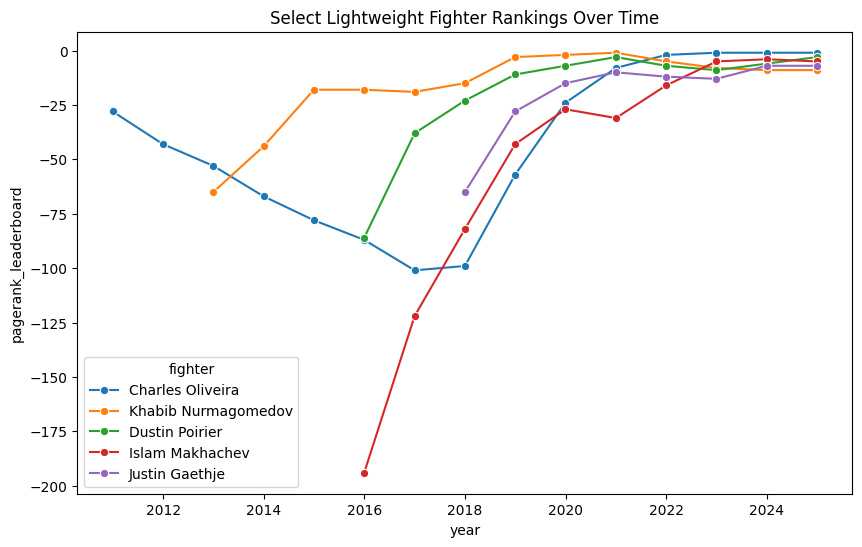

In [161]:
plt.figure(figsize=(10, 6))
plt.title('Select Lightweight Fighter Rankings Over Time')
graph_df = final_dfs['Lightweight']
fighter_ls = ['Justin Gaethje', 'Khabib Nurmagomedov', 'Dustin Poirier', 'Charles Oliveira', 'Islam Makhachev']
sns.lineplot(data=graph_df[graph_df.fighter.isin(fighter_ls)], x='year', y='pagerank_leaderboard', hue='fighter', marker='o')

### Pagerank Ranking Over Time of Select Featherweight Fighters
Notable amongst featherweights is the dominance of Max Holloway, Jose Aldo, and Conor McGregor in the division with them being so near the top for so long. Also Alexander Volkanovski's rise from no-name fighter to champion is visible in the graph below:

<Axes: title={'center': 'Select Featherweight Fighter Rankings Over Time'}, xlabel='year', ylabel='pagerank_leaderboard'>

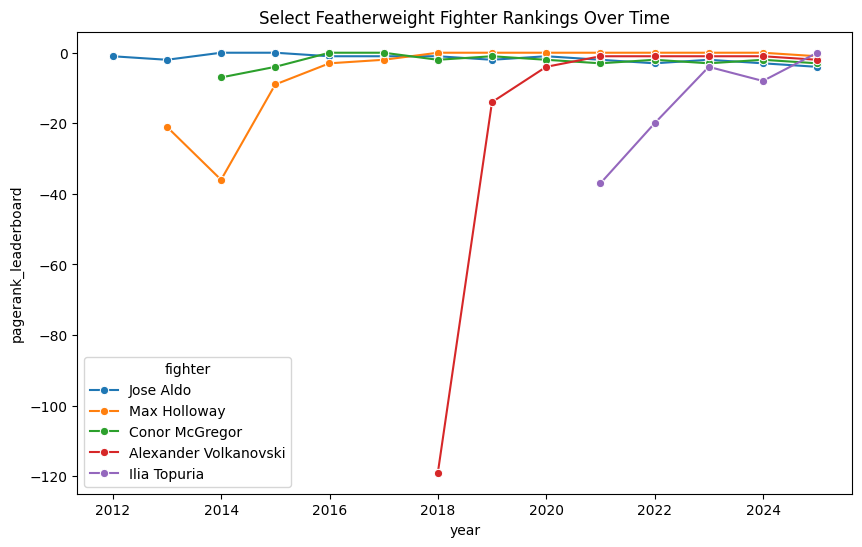

In [162]:
plt.figure(figsize=(10, 6))
plt.title('Select Featherweight Fighter Rankings Over Time')
graph_df = final_dfs['Featherweight']
fighter_ls = ['Jose Aldo', 'Conor McGregor', 'Max Holloway', 'Alexander Volkanovski', 'Ilia Topuria']
sns.lineplot(data=graph_df[graph_df.fighter.isin(fighter_ls)], x='year', y='pagerank_leaderboard', hue='fighter', marker='o')

### Pagerank Ranking Over Time of Select Bantamweight Fighters

<Axes: title={'center': 'Select Bantamweight Fighter Rankings Over Time'}, xlabel='year', ylabel='pagerank_leaderboard'>

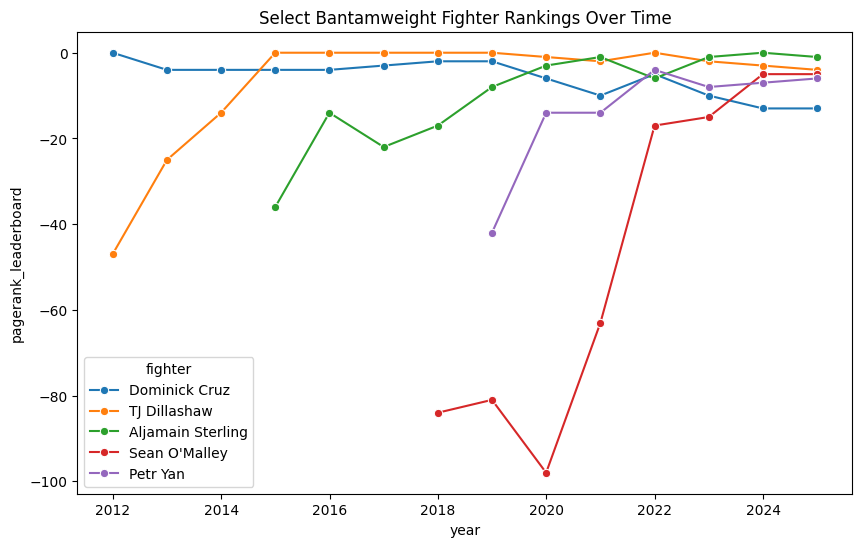

In [164]:

plt.figure(figsize=(10, 6))
plt.title('Select Bantamweight Fighter Rankings Over Time')
graph_df = final_dfs['Bantamweight']
fighter_ls = ['TJ Dillashaw', 'Dominick Cruz', 'Petr Yan', 'Aljamain Sterling', "Sean O'Malley"]
sns.lineplot(data=graph_df[graph_df.fighter.isin(fighter_ls)], x='year', y='pagerank_leaderboard', hue='fighter', marker='o')

###  Pagerank Ranking Over Time of Select Heavyweight Fighters

<Axes: title={'center': 'Select Heavyweight Fighter Rankings Over Time'}, xlabel='year', ylabel='pagerank_leaderboard'>

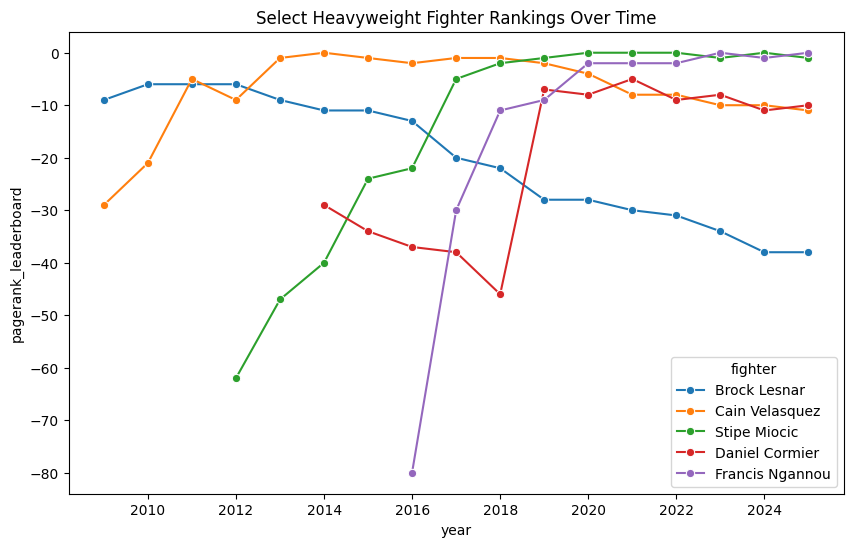

In [166]:
plt.figure(figsize=(10, 6))
plt.title('Select Heavyweight Fighter Rankings Over Time')
graph_df = final_dfs['Heavyweight']
fighter_ls = ['Brock Lesnar', 'Stipe Miocic', 'Daniel Cormier', 'Francis Ngannou', 'Cain Velasquez']
sns.lineplot(data=graph_df[graph_df.fighter.isin(fighter_ls)], x='year', y='pagerank_leaderboard', hue='fighter', marker='o')